# Compare DE results from perturb-seq with arrayed screen RNA-seq

In [1]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy
import re
import pertpy as pt

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from DE_analysis_utils import *

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/utils.py:435: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/utils.py:435: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/utils.py:435: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/utils.py:435: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rap

In [2]:
# datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4iR1_Psomagen/'
# experiment_name = 'CD4iR1_Psomagen'
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
experiment_name = 'CD4i_final'

## Reprocess Freimer et al arrayed RNA-seq data with DESeq2

In [3]:
freimer_raw = pd.read_csv('../../metadata/Freimer_et_al_raw.csv')

# Convert into anndata
var_df = pd.DataFrame(index=freimer_raw['gene_id'].apply(lambda x: re.sub(r'\.\d+$', '', x)))
var_df.index.name = 'gene_id' # Naming the index of .var
sample_cols = freimer_raw.columns.drop('gene_id')
obs_df = pd.DataFrame(index=sample_cols)
obs_df['donor'] = obs_df.index.map(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
obs_df['sgRNA'] = obs_df.index.map(lambda x: '_'.join(x.split('_')[2:]))
obs_df['target_gene'] = obs_df['sgRNA'].apply(lambda x: "Non-targeting" if "AAVS1" in x else x)
X = freimer_raw[sample_cols].T
X.columns = var_df.index
adata = anndata.AnnData(X=X, obs=obs_df, var=var_df)
adata.var['gene_id'] = adata.var.index

# Perform DESeq2
model = pt.tl.PyDESeq2(adata, design='~ donor + target_gene')
model.fit(quiet=True)

# Extract and parse results
all_res_df = pd.DataFrame()
all_targets = adata.obs['target_gene'].unique().tolist()
all_targets.remove('Non-targeting')
for t in all_targets:
    t_contrast = (model.cond(target_gene = t) - model.cond(target_gene = 'Non-targeting')) 
    res_df = model.test_contrasts(t_contrast)
    res_df['contrast'] = t
    all_res_df = pd.concat([all_res_df, res_df])

all_res_df = all_res_df.reset_index().drop('index', axis=1)

all_dfs = {}
for stat in ['baseMean', 'log_fc', 'lfcSE', 'p_value','adj_p_value']:
    stat_df = all_res_df.pivot(values=stat, columns='variable', index='contrast')
    all_dfs[stat] = stat_df

DE_anndata = anndata.AnnData(
    layers = all_dfs.copy()
)

DE_anndata.obs_names = all_dfs['log_fc'].index.tolist()
DE_anndata.var_names = all_dfs['log_fc'].columns.tolist()
DE_anndata.obs['target_gene'] = DE_anndata.obs_names.values
DE_anndata.var['gene_id'] = DE_anndata.var_names

DE_anndata.write_h5ad('../../metadata/Freimer_et_al_DEseq2.h5ad')

Running Wald tests...
... done in 2.39 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  1.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831        0.067289  8.898000  0.007562  0.993966   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959        0.347802  0.154231  2.255076  0.024129   
ENSG00000210194     1.161547       -0.163270  0.973936 -0.167639  0.866867   
ENSG00000198727  7900.479325        0.030250  0.061830

Running Wald tests...
... done in 2.49 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  1.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831       -0.041673  8.898395 -0.004683  0.996263   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959       -0.099169  0.155770 -0.636641  0.524359   
ENSG00000210194     1.161547        0.168230  0.872584  0.192795  0.847120   
ENSG00000198727  7900.479325        0.005203  0.061789

Running Wald tests...
... done in 2.38 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831        1.006105  8.794589  0.114400  0.908920   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959       -0.024130  0.155845 -0.154833  0.876953   
ENSG00000210194     1.161547       -2.601093  1.989754 -1.307243  0.191130   
ENSG00000198727  7900.479325       -0.153634  0.061915

Running Wald tests...
... done in 3.06 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  1.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831        0.215354  8.898177  0.024202  0.980691   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959        0.415306  0.154537  2.687414  0.007201   
ENSG00000210194     1.161547        0.432152  0.873066  0.494982  0.620613   
ENSG00000198727  7900.479325        0.038784  0.061906

Running Wald tests...
... done in 2.42 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  1.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831        0.173318  8.898400  0.019477  0.984460   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959        0.054353  0.156078  0.348239  0.727661   
ENSG00000210194     1.161547       -0.608647  1.125767 -0.540651  0.588748   
ENSG00000198727  7900.479325        0.044677  0.061876

Running Wald tests...
... done in 3.19 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831        0.038308  8.897912  0.004305  0.996565   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959       -0.171752  0.156510 -1.097386  0.272473   
ENSG00000210194     1.161547        0.225758  0.877433  0.257294  0.796952   
ENSG00000198727  7900.479325       -0.110793  0.061887

Running Wald tests...
... done in 3.23 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831        0.043107  8.898084  0.004845  0.996135   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959        0.037255  0.155493  0.239595  0.810644   
ENSG00000210194     1.161547        0.834784  0.768715  1.085948  0.277502   
ENSG00000198727  7900.479325       -0.050680  0.061858

Running Wald tests...
... done in 2.48 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  1.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831       -0.082496  8.898139 -0.009271  0.992603   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959       -0.095714  0.155494 -0.615549  0.538192   
ENSG00000210194     1.161547       -1.766137  1.475313 -1.197127  0.231257   
ENSG00000198727  7900.479325        0.027418  0.061762

Running Wald tests...
... done in 2.87 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831        0.148639  8.897872  0.016705  0.986672   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959        0.051183  0.155900  0.328308  0.742679   
ENSG00000210194     1.161547        0.662572  0.814953  0.813019  0.416207   
ENSG00000198727  7900.479325        0.082177  0.061845

Running Wald tests...
... done in 2.57 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831        0.090120  8.899104  0.010127  0.991920   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959        0.235077  0.154867  1.517928  0.129033   
ENSG00000210194     1.161547       -0.126537  0.968524 -0.130650  0.896052   
ENSG00000198727  7900.479325        0.058676  0.061829

Running Wald tests...
... done in 2.90 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831        0.051622  8.898234  0.005801  0.995371   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959        0.119820  0.155095  0.772554  0.439786   
ENSG00000210194     1.161547        1.429562  0.689347  2.073793  0.038099   
ENSG00000198727  7900.479325        0.103601  0.061789

Running Wald tests...
... done in 2.51 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831        0.026306  8.899387  0.002956  0.997642   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959        0.035018  0.155467  0.225245  0.821789   
ENSG00000210194     1.161547        0.552802  0.810178  0.682322  0.495035   
ENSG00000198727  7900.479325        0.016966  0.061817

Running Wald tests...
... done in 2.35 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat  \
gene_id                                                            
ENSG00000223972     0.000000             NaN       NaN       NaN   
ENSG00000227232     0.010831       -0.127337  8.900154 -0.014307   
ENSG00000278267     0.000000             NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN   
...                      ...             ...       ...       ...   
ENSG00000198695   330.768959       -0.366618  0.156629 -2.340678   
ENSG00000210194     1.161547        0.058654  0.877280  0.066859   
ENSG00000198727  7900.479325       -0.478962  0.062022 -7.722490   
ENSG00000210195    69.661925       -0.392689  0.168196 -2.334712   
ENSG00000210196   

Running Wald tests...
... done in 2.72 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831        0.088927  8.900501  0.009991  0.992028   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959       -0.056104  0.156264 -0.359032  0.719571   
ENSG00000210194     1.161547       -0.713058  1.123841 -0.634484  0.525765   
ENSG00000198727  7900.479325       -0.043268  0.061884

Running Wald tests...
... done in 2.61 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831        0.019106  8.899468  0.002147  0.998287   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959        0.204034  0.154667  1.319187  0.187107   
ENSG00000210194     1.161547       -2.626327  1.976330 -1.328891  0.183884   
ENSG00000198727  7900.479325        0.113606  0.061769

Running Wald tests...
... done in 2.40 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831       -0.046267  8.893267 -0.005203  0.995849   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959       -0.129212  0.155960 -0.828493  0.407392   
ENSG00000210194     1.161547        0.456902  0.814143  0.561207  0.574657   
ENSG00000198727  7900.479325        0.211992  0.061697

Running Wald tests...
... done in 2.75 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831       -0.064673  8.899042 -0.007267  0.994202   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959       -0.116120  0.155767 -0.745473  0.455986   
ENSG00000210194     1.161547       -0.373964  0.989064 -0.378099  0.705357   
ENSG00000198727  7900.479325        0.023126  0.061770

Running Wald tests...
... done in 2.36 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831        0.036863  8.899505  0.004142  0.996695   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959        0.246856  0.154597  1.596770  0.110317   
ENSG00000210194     1.161547       -0.847828  1.153813 -0.734805  0.462458   
ENSG00000198727  7900.479325        0.212594  0.061732

Running Wald tests...
... done in 2.61 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831       -0.016601  8.898835 -0.001866  0.998512   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959       -0.153953  0.156168 -0.985811  0.324226   
ENSG00000210194     1.161547       -1.700239  1.462411 -1.162628  0.244981   
ENSG00000198727  7900.479325        0.138726  0.061740

Running Wald tests...
... done in 2.50 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831       -0.273993  8.903746 -0.030773  0.975451   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959       -0.139401  0.155012 -0.899288  0.368499   
ENSG00000210194     1.161547        1.206795  0.678661  1.778199  0.075371   
ENSG00000198727  7900.479325       -0.091695  0.061749

Running Wald tests...
... done in 2.65 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831       -0.141588  8.901491 -0.015906  0.987309   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959       -0.162295  0.155604 -1.042998  0.296949   
ENSG00000210194     1.161547       -1.825230  1.475300 -1.237193  0.216016   
ENSG00000198727  7900.479325       -0.049365  0.061786

Running Wald tests...
... done in 2.85 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  1.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831       -0.144396  8.901504 -0.016222  0.987058   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959       -0.061606  0.155168 -0.397028  0.691347   
ENSG00000210194     1.161547       -0.366850  0.972331 -0.377289  0.705959   
ENSG00000198727  7900.479325       -0.132758  0.061821

Running Wald tests...
... done in 2.37 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  1.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831       -0.032928  8.898219 -0.003701  0.997047   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959       -0.098292  0.155743 -0.631117  0.527964   
ENSG00000210194     1.161547        0.171781  0.875600  0.196187  0.844464   
ENSG00000198727  7900.479325       -0.083744  0.061840

Running Wald tests...
... done in 2.74 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                      
ENSG00000223972     0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232     0.010831        0.136602  8.899361  0.015350  0.987753   
ENSG00000278267     0.000000             NaN       NaN       NaN       NaN   
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332     0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSG00000198695   330.768959       -0.060723  0.156524 -0.387947  0.698055   
ENSG00000210194     1.161547       -0.147262  0.981401 -0.150053  0.880723   
ENSG00000198727  7900.479325       -0.047275  0.061908

## Read best Perturb-seq DE results

In [85]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')
# Annotate zscore
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.obs['target_contrast'].nunique()

11527

In [ ]:
# Filter very lowly expressed genes
base_mean_df = sc.get.obs_df(adata_de, adata_de.var_names.tolist() + ['culture_condition', 'chunk'], layer='baseMean')
base_mean_df = base_mean_df.drop_duplicates().sort_values('culture_condition')

base_mean_rest = base_mean_df[base_mean_df['culture_condition'] == 'Rest'].set_index('chunk').drop('culture_condition', axis=1).T

adata_de.var['mean_baseMean_Rest'] = base_mean_rest.mean(1).fillna(0)
adata_de.var['std_baseMean_Rest'] = base_mean_rest.std(1).fillna(10000)

# Exclude from analysis genes with very low base mean (messing up reliability estimate)
gs_mask = adata_de.var['mean_baseMean_Rest'] > 0.2
adata_de = adata_de[:, gs_mask].copy()
sum(~gs_mask)

3313

In [88]:
# Match condition
adata_de = adata_de[adata_de.obs['culture_condition'] == 'Rest'].copy()


In [92]:
# Filter targets with significant KD of the gene
de_stats = pd.read_csv(f'{datadir}/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
de_stats = de_stats[de_stats['condition'] == 'Rest'].copy()
ontarget_effect_targets = de_stats[de_stats['ontarget_significant']].target_name.tolist()
adata_de = adata_de[adata_de.obs['target_contrast_gene_name'].isin(ontarget_effect)].copy()

## Compare to Freimer et al arrayed RNA-seq

In [ ]:
# adata_freimer = sc.read_h5ad('../../metadata/Freimer_et_al_DEseq2.h5ad')
adata_freimer = sc.read_h5ad('data/Freimer_et_al_DE.h5ad')
adata_freimer.layers['zscore'] = adata_freimer.layers['log_fc'] / adata_freimer.layers['lfcSE']

In [152]:
thre = 0.1 # Significance threshold

common_perturbations = np.intersect1d(adata_freimer.obs.target_gene, adata_de.obs['target_contrast_gene_name'])
# Only consider perturbations that have >=100 DE genes in either Freimer et al arrayed RNAseq or Perturb-seq dataset
sig_number = np.zeros(len(common_perturbations))
for i, g in enumerate(common_perturbations):
    freimer_set = set(adata_freimer[:,adata_freimer[adata_freimer.obs['target_gene']==g].layers['adj_p_value']<thre].var.gene_id)
    perturbseq_set = set(adata_de[:,adata_de[adata_de.obs['target_contrast_gene_name']==g].layers['adj_p_value']<thre].var.gene_ids)
    sig_number[i] = len(freimer_set | perturbseq_set)
sig_number = sig_number.astype(int)
common_sig_perturbations = common_perturbations[sig_number>=100]
print(common_sig_perturbations)

['ATXN7L3' 'CBFB' 'FOXK1' 'GATA3' 'IL2RA' 'IRF1' 'IRF2' 'KLF2' 'MBD2'
 'MED12' 'MYB' 'PTEN' 'STAT5A' 'STAT5B' 'YY1']


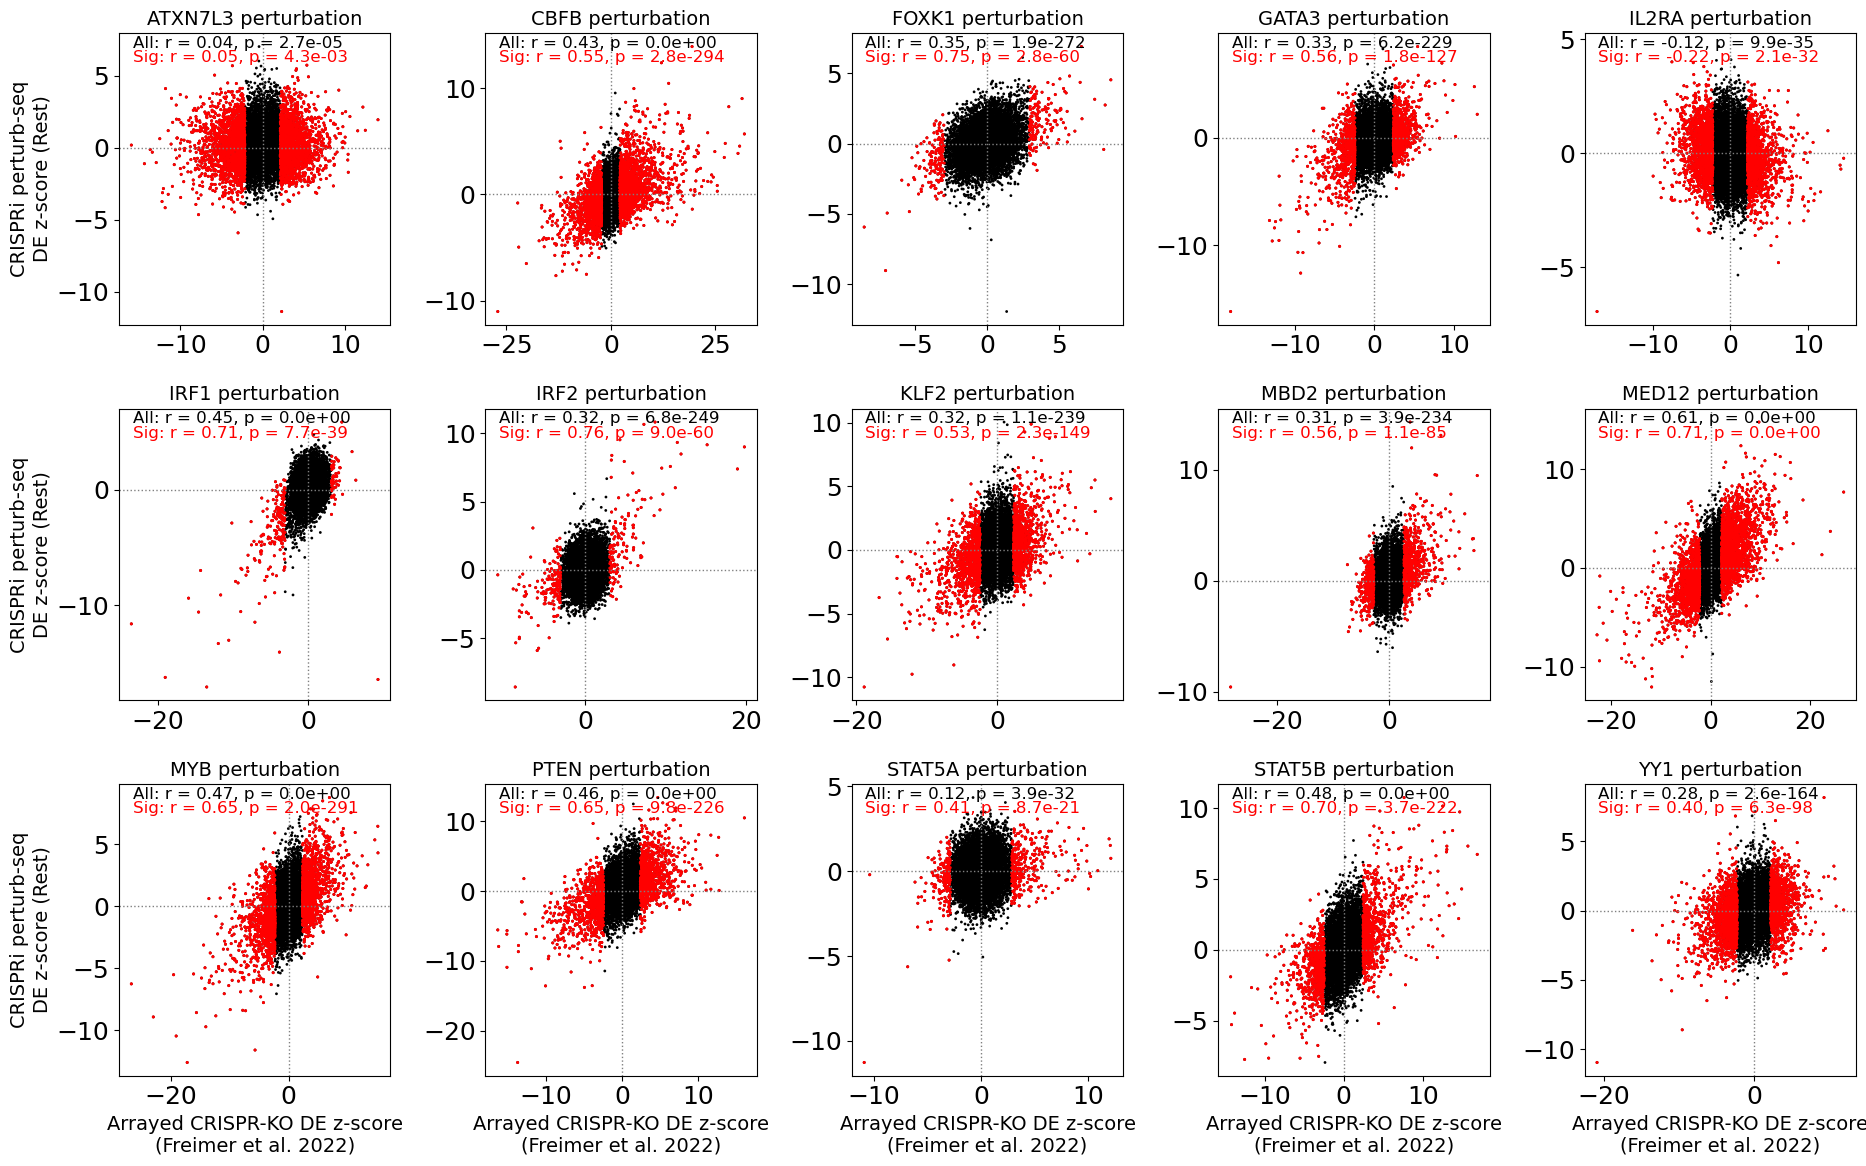

In [153]:
rest_signif_corr_all = np.zeros([len(common_sig_perturbations),2])
gwt_signif = np.zeros(len(common_sig_perturbations))
ko_signif = np.zeros(len(common_sig_perturbations))

# Calculate number of rows and columns needed
n_plots = len(common_sig_perturbations)
n_cols = 5  # Fixed number of columns
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division

# Create a figure with only the needed number of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(19, 4*n_rows))
if n_rows == 1:
    axes = axes.reshape(-1)  # Convert to 1D array if only one row
else:
    axes = axes.reshape(-1)  # Convert to 1D array

# Remove extra subplots
for ax in axes[n_plots:]:
    ax.remove()
axes = axes[:n_plots]  # Only keep the needed number of subplots

for i, g in enumerate(common_sig_perturbations):
    # Get data for this perturbation
    gwt_effect_g = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='zscore')
    gwt_effect_g.columns = ['perturbseq_zscore']
    gwt_effect_g['perturbseq_signif'] = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='adj_p_value')
    freimer_effect_g = sc.get.var_df(adata_freimer, adata_freimer.obs_names[adata_freimer.obs['target_gene'] == g].tolist(), layer='zscore')
    freimer_effect_g.columns = ['freimer_zscore']
    freimer_effect_g['freimer_signif'] = sc.get.var_df(adata_freimer, adata_freimer.obs_names[adata_freimer.obs['target_gene'] == g].tolist(), layer='adj_p_value')

    concat_df = pd.concat([freimer_effect_g, gwt_effect_g], axis=1).dropna()

    # Calculate correlation coefficients and p-values for Rest condition only
    rest_corr, rest_pval = scipy.stats.pearsonr(concat_df['freimer_zscore'], concat_df['perturbseq_zscore'])
    rest_signif_corr, rest_signif_pval = scipy.stats.pearsonr(
        concat_df[concat_df['freimer_signif']<thre]['freimer_zscore'], 
        concat_df[concat_df['freimer_signif']<thre]['perturbseq_zscore']
    ) if sum(concat_df['freimer_signif']<thre) > 1 else (float('nan'), float('nan'))
    
    # Create scatter plot for Rest condition
    sns.scatterplot(data=concat_df, x='freimer_zscore', y='perturbseq_zscore', s=4, edgecolor='none', color='black', ax=axes[i])
    sns.scatterplot(data=concat_df[concat_df['freimer_signif']<thre],
                    x='freimer_zscore', y='perturbseq_zscore', s=5, edgecolor='none', color='red', ax=axes[i])

    # Add correlation information as text
    axes[i].annotate(f'All: r = {rest_corr:.2f}, p = {rest_pval:.1e}', 
                xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
    if not np.isnan(rest_signif_corr):
        axes[i].annotate(f'Sig: r = {rest_signif_corr:.2f}, p = {rest_signif_pval:.1e}', 
                    xy=(0.05, 0.90), xycoords='axes fraction', fontsize=12, color='red')

    # Add dotted lines for x and y axes
    axes[i].axhline(y=0, color='gray', linestyle=':', linewidth=1)
    axes[i].axvline(x=0, color='gray', linestyle=':', linewidth=1)
    
    # Set title and labels
    axes[i].set_title(f'{g} perturbation', fontsize=14)
    
    # Only add y-label for plots in the first column
    if i % n_cols == 0:
        axes[i].set_ylabel('CRISPRi perturb-seq\nDE z-score (Rest)', fontsize=14)
    else:
        axes[i].set_ylabel('')
    
    # Only add x-label for plots in the bottom row
    if i >= n_plots - n_cols:
        axes[i].set_xlabel('Arrayed CRISPR-KO DE z-score\n(Freimer et al. 2022)', fontsize=14)
    else:
        axes[i].set_xlabel('')

    rest_signif_corr_all[i,0] = rest_signif_corr
    rest_signif_corr_all[i,1] = rest_signif_pval
    gwt_signif[i] = np.sum(concat_df['perturbseq_signif']<thre)
    ko_signif[i] = np.sum(concat_df['freimer_signif']<thre)

plt.tight_layout()
plt.savefig('results/freimer_et_al_comparison_scatter.png')
plt.savefig('results/freimer_et_al_comparison_scatter.pdf')

plt.show()

In [11]:
# for i, g in enumerate(common_sig_perturbations):
#     # Get data for this perturbation
#     gwt_effect_g = gwt_effect[target_co]
#     gwt_effect_g.columns = ['perturbseq_zscore']
#     gwt_effect_g['perturbseq_signif'] = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='adj_p_value')

#     freimer_effect_g = sc.get.var_df(adata_freimer, adata_freimer.obs_names[adata_freimer.obs['target_gene'] == g].tolist(), layer='zscore')
#     freimer_effect_g.columns = ['freimer_zscore']
#     freimer_effect_g['freimer_signif'] = sc.get.var_df(adata_freimer, adata_freimer.obs_names[adata_freimer.obs['target_gene'] == g].tolist(), layer='adj_p_value')

#     # Calculate correlation coefficients and p-values between DE effects
#     rest_corr, rest_pval = scipy.stats.pearsonr(concat_df['freimer_zscore'], concat_df['perturbseq_zscore'])
#     rest_signif_corr, rest_signif_pval = scipy.stats.pearsonr(
#         concat_df[concat_df['freimer_signif']<thre]['freimer_zscore'], 
#         concat_df[concat_df['freimer_signif']<thre]['perturbseq_zscore']
#     ) if sum(concat_df['freimer_signif']<thre) > 1 else (float('nan'), float('nan'))    

In [12]:
# gwt_signif = gwt_signif.astype(int)
# ko_signif = ko_signif.astype(int)
# num_signif = pd.DataFrame({'gwt_signif': gwt_signif, 'ko_signif': ko_signif})
# # Create a simple DataFrame
# df = pd.DataFrame({'r': rest_signif_corr_all[:,0], 'pvalue': rest_signif_corr_all[:,1]})

# fig, ax = plt.subplots(1, 2, figsize=(10,5))
# # Plot box & stripplot
# plt.figure(figsize=(4, 6))
# sns.boxplot(data=df, y='r', color='lightblue', width=0.5, ax=ax[0])
# sns.stripplot(data=df, y='r', color='black', size=6, jitter=True, alpha=0.7, ax=ax[0])

# ax[0].set_ylabel("Pearson r")
# ax[0].set_ylim(-1, 1)  # since r ranges from -1 to 1

# ax[1].plot(np.min(num_signif, axis=1)/np.sum(num_signif, axis=1), rest_signif_corr_all[:,0], '.')
# ax[1].set_xlabel('Minimum DE / sum DE')
# ax[1].set_ylabel('Pearson r')

# sns.despine()
# plt.tight_layout()
# plt.show()

In [13]:
# fig, ax = plt.subplots(figsize=(4.8,4))
# scatter = ax.scatter(num_signif.gwt_signif, num_signif.ko_signif, c=rest_signif_corr_all[:,0])
# cbar = fig.colorbar(scatter, ax=ax, label='pearson r')
# ax.set_xlabel('Number of Perturb-seq DE genes')
# ax.set_ylabel('Number of Weinstock DE genes')
# ax.set_xscale('log')
# ax.set_yscale('log')
# sns.despine()

## Compare to Weinstock et al arrayed RNA-seq

In [97]:
weinstock_df = pd.read_csv('../../metadata/TableS4_weinstock_et_al_DE.csv')
weinstock_kos = weinstock_df['KO'].unique().tolist()
common_perturbations = np.intersect1d(weinstock_kos, adata_de[adata_de.obs.culture_condition == 'Rest'].obs['target_contrast_gene_name'])
weinstock_df['zscore'] = weinstock_df['log2FoldChange'] / weinstock_df['lfcSE']
weinstock_df['gene_id'] = weinstock_df['gene_id'].str.split('.').str[0]

In [156]:
common_perturbations = np.intersect1d(weinstock_kos, adata_de[adata_de.obs.culture_condition == 'Rest'].obs['target_contrast_gene_name'])

thre = 0.05 # Significance threshold
# Only consider perturbations that have >=100 DE genes in either Weinstock et al arrayed RNAseq or Perturb-seq dataset
sig_number = np.zeros(len(common_perturbations))
for i, g in enumerate(common_perturbations):
    weinstock_set = set(weinstock_df[(weinstock_df['KO'] == g)&(weinstock_df.padj<thre)].gene_id) 
    perturbseq_set = set(adata_de[:,adata_de[adata_de.obs['target_contrast_gene_name']==g].layers['adj_p_value']<thre].var.gene_ids)
    sig_number[i] = len(weinstock_set | perturbseq_set)
sig_number = sig_number.astype(int)
common_sig_perturbations = common_perturbations[sig_number>=100]

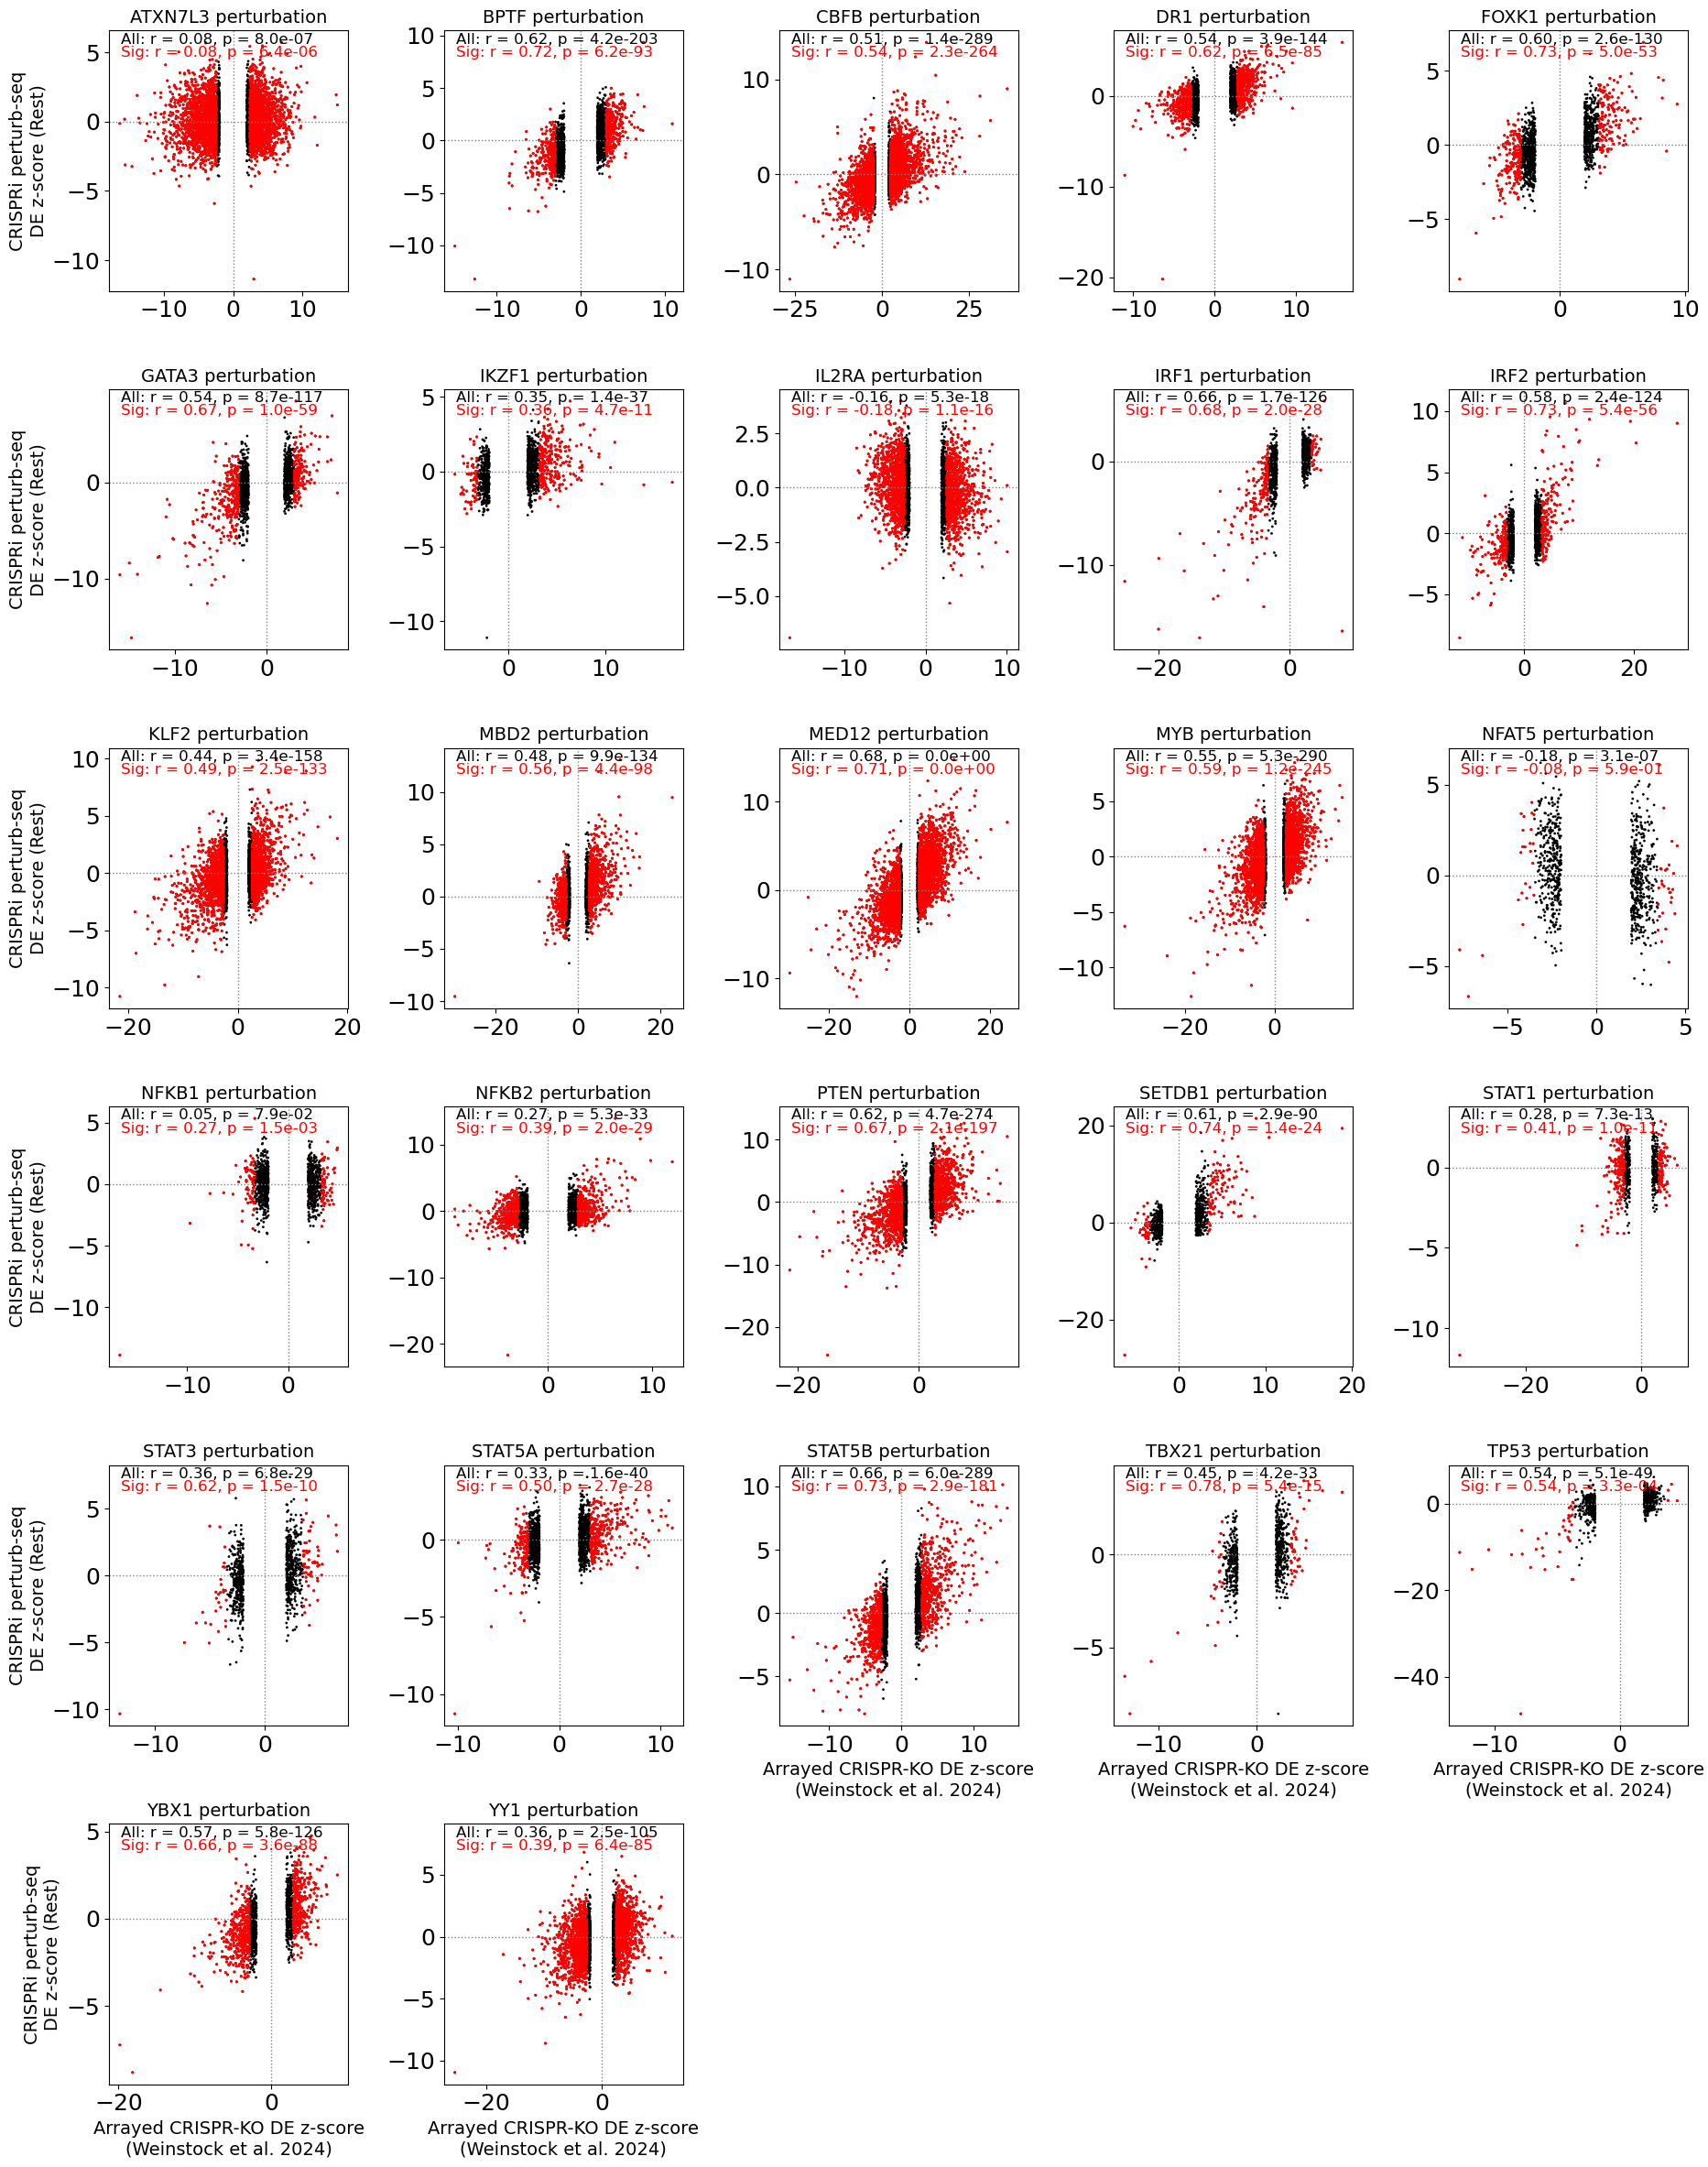

In [157]:
rest_signif_corr_all = np.zeros([len(common_sig_perturbations),2])
gwt_signif = np.zeros(len(common_sig_perturbations))
ko_signif = np.zeros(len(common_sig_perturbations))

# Calculate number of rows and columns needed
n_plots = len(common_sig_perturbations)
n_cols = 5  # Fixed number of columns
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division

# Create a figure with only the needed number of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(19, 4*n_rows))
if n_rows == 1:
    axes = axes.reshape(-1)  # Convert to 1D array if only one row
else:
    axes = axes.reshape(-1)  # Convert to 1D array

# Remove extra subplots
for ax in axes[n_plots:]:
    ax.remove()
axes = axes[:n_plots]  # Only keep the needed number of subplots

for i, g in enumerate(common_sig_perturbations):
    # Get data for this perturbation
    gwt_effect_g = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='zscore')
    gwt_effect_g.columns = ['perturbseq_zscore']
    gwt_effect_g['perturbseq_signif'] = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='adj_p_value')
    weinstock_effect_g = weinstock_df[weinstock_df['KO'] == g].set_index('gene_id')[['zscore']]
    weinstock_effect_g.columns = ['weinstock_zscore']
    weinstock_effect_g['weinstock_signif'] = weinstock_df[weinstock_df['KO'] == g].set_index('gene_id')[['padj']]

    concat_df = pd.concat([weinstock_effect_g, gwt_effect_g], axis=1).dropna()

    # Calculate correlation coefficients and p-values for Rest condition only
    rest_corr, rest_pval = scipy.stats.pearsonr(concat_df['weinstock_zscore'], concat_df['perturbseq_zscore'])
    rest_signif_corr, rest_signif_pval = scipy.stats.pearsonr(
        concat_df[concat_df['weinstock_signif']<thre]['weinstock_zscore'], 
        concat_df[concat_df['weinstock_signif']<thre]['perturbseq_zscore']
    ) if sum(concat_df['weinstock_signif']<thre) > 1 else (float('nan'), float('nan'))

    
    # Create scatter plot for Rest condition
    sns.scatterplot(data=concat_df, x='weinstock_zscore', y='perturbseq_zscore', s=4, edgecolor='none', color='black', ax=axes[i])
    sns.scatterplot(data=concat_df[concat_df['weinstock_signif']<thre],
                    x='weinstock_zscore', y='perturbseq_zscore', s=5, edgecolor='none', color='red', ax=axes[i])

    # Add correlation information as text
    axes[i].annotate(f'All: r = {rest_corr:.2f}, p = {rest_pval:.1e}', 
                xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
    if not np.isnan(rest_signif_corr):
        axes[i].annotate(f'Sig: r = {rest_signif_corr:.2f}, p = {rest_signif_pval:.1e}', 
                    xy=(0.05, 0.90), xycoords='axes fraction', fontsize=12, color='red')

    # Add dotted lines for x and y axes
    axes[i].axhline(y=0, color='gray', linestyle=':', linewidth=1)
    axes[i].axvline(x=0, color='gray', linestyle=':', linewidth=1)
    
    # Set title and labels
    axes[i].set_title(f'{g} perturbation', fontsize=14)
    
    # Only add y-label for plots in the first column
    if i % n_cols == 0:
        axes[i].set_ylabel('CRISPRi perturb-seq\nDE z-score (Rest)', fontsize=14)
    else:
        axes[i].set_ylabel('')
    
    # Only add x-label for plots in the bottom row
    if i >= n_plots - n_cols:
        axes[i].set_xlabel('Arrayed CRISPR-KO DE z-score\n(Weinstock et al. 2024)', fontsize=14)
    else:
        axes[i].set_xlabel('')

    rest_signif_corr_all[i,0] = rest_signif_corr
    rest_signif_corr_all[i,1] = rest_signif_pval
    gwt_signif[i] = np.sum(concat_df['perturbseq_signif']<thre)
    ko_signif[i] = np.sum(concat_df['weinstock_signif']<thre)

plt.tight_layout()
plt.savefig('results/weinstock_et_al_comparison_scatter.png')
plt.savefig('results/weinstock_et_al_comparison_scatter.pdf')

plt.show()

In [217]:
# gwt_signif = gwt_signif.astype(int)
# ko_signif = ko_signif.astype(int)
# num_signif = pd.DataFrame({'gwt_signif': gwt_signif, 'ko_signif': ko_signif})
# # Create a simple DataFrame
# df = pd.DataFrame({'r': rest_signif_corr_all[:,0], 'pvalue': rest_signif_corr_all[:,1]})

# fig, ax = plt.subplots(1, 2, figsize=(10,5))
# # Plot box & stripplot
# plt.figure(figsize=(4, 6))
# sns.boxplot(data=df, y='r', color='lightblue', width=0.5, ax=ax[0])
# sns.stripplot(data=df, y='r', color='black', size=6, jitter=True, alpha=0.7, ax=ax[0])

# ax[0].set_ylabel("Pearson r")
# ax[0].set_ylim(-1, 1)  # since r ranges from -1 to 1

# ax[1].plot(np.min(num_signif, axis=1)/np.sum(num_signif, axis=1), rest_signif_corr_all[:,0], '.')
# ax[1].set_xlabel('Minimum DE / sum DE')
# ax[1].set_ylabel('Pearson r')

# sns.despine()
# plt.tight_layout()
# plt.show()

In [218]:
# fig, ax = plt.subplots(figsize=(4.8,4))
# scatter = ax.scatter(num_signif.gwt_signif, num_signif.ko_signif, c=rest_signif_corr_all[:,0])
# cbar = fig.colorbar(scatter, ax=ax, label='pearson r')
# ax.set_xlabel('Number of Perturb-seq DE genes')
# ax.set_ylabel('Number of Weinstock DE genes')
# ax.set_xscale('log')
# ax.set_yscale('log')
# sns.despine()

## Make summary figure

In [158]:
def get_reliability(x, sigma):
    sigma2_obs = np.var(x, ddof=1)  # Observed variance across features
    sigma2_sem = np.mean(sigma**2)   # Average squared standard error
    sigma2_true = sigma2_obs - sigma2_sem  # Estimated true signal variance
    reliability = sigma2_true / (sigma2_true + sigma2_sem)
    return(reliability)

def get_max_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    rel_a = get_reliability(x_a, sigma_a)
    rel_b = get_reliability(x_b, sigma_b)
    return np.sqrt(rel_a * rel_b)

def get_lfc_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    corr = x_a.corr(x_b)
    corr_ceil = get_max_correlation(x_a, sigma_a, x_b, sigma_b)
    return corr, corr_ceil
    
def comparison_r(gwt_zscore, freimer_zscore_signif, common_sig_perturbations, bootstrap_seed = 42, bootstrap_frac = 0.70):
    '''Calculate correlation between all gwt targets and all freimer targets, with bootstrapping.'''
    # Create two square dataframes for r and p values
    target_corr_r = pd.DataFrame(index=common_sig_perturbations, columns=common_sig_perturbations)
    target_corr_p = pd.DataFrame(index=common_sig_perturbations, columns=common_sig_perturbations)

    # Get common genes between datasets
    common_gs = np.intersect1d(gwt_zscore.index, freimer_zscore_signif.index)

    # Calculate correlations between all pairs of targets
    for target_gwt in common_sig_perturbations:
        for target_freimer in common_sig_perturbations:
            # Get non-null values
            mask = ~freimer_zscore_signif.loc[common_gs][target_freimer].isna()
            # bootstrap
            rng = np.random.default_rng(bootstrap_seed)
            n_to_switch = int(sum(mask) * (1 - bootstrap_frac))
            true_indices = np.where(mask)[0]
            indices_to_switch = rng.choice(true_indices, size=n_to_switch, replace=False)
            mask[indices_to_switch] = False
            if sum(mask) > 2:  # Need at least 2 points for correlation
                r, p = scipy.stats.pearsonr(
                    gwt_zscore.loc[common_gs][target_gwt][mask].fillna(0),
                    freimer_zscore_signif.loc[common_gs][target_freimer][mask]
                )
                # Store correlation and p-value in separate matrices
                target_corr_r.loc[target_gwt, target_freimer] = r
                target_corr_p.loc[target_gwt, target_freimer] = p
            else:
                target_corr_r.loc[target_gwt, target_freimer] = np.nan
                target_corr_p.loc[target_gwt, target_freimer] = np.nan

    # Melt the upper triangle only
    # mask = np.triu(np.ones(target_corr_r.shape)).astype(bool)
    target_corr = pd.DataFrame({
        'r': target_corr_r.melt(ignore_index=False)['value'].dropna(),
        'p': target_corr_p.melt(ignore_index=False)['value'].dropna(),
        'gene_GWT': target_corr_r.melt(ignore_index=False).dropna().index,
        'gene_freimer': target_corr_r.melt(ignore_index=False).dropna()['variable']
    })

    target_corr['same_target'] = target_corr['gene_freimer'] == target_corr['gene_GWT']
    return(target_corr)

def comparison_lfc_r(gwt_lfc, gwt_sigma, freimer_lfc, freimer_sigma, common_sig_perturbations, bootstrap_seed = 42, bootstrap_frac = 0.70):
    '''Calculate correlation and maximum possible correlation between all gwt targets and all freimer targets, with bootstrapping.'''
    # Create dataframes for r and r_ceiling values
    target_corr_r = pd.DataFrame(index=common_sig_perturbations, columns=common_sig_perturbations)
    target_corr_ceil = pd.DataFrame(index=common_sig_perturbations, columns=common_sig_perturbations)

    # Calculate correlations between all pairs of targets
    for target_gwt in common_sig_perturbations:
        for target_freimer in common_sig_perturbations:
            # Get genes with non-NA values in both datasets for these targets
            # Get indices that exist in both datasets
            common_idx = np.intersect1d(gwt_lfc.index, freimer_lfc.index)
            gwt_target = gwt_lfc.loc[common_idx, target_gwt].dropna()
            freimer_target = freimer_lfc.loc[common_idx, target_freimer].dropna()
            gwt_target_sigma = gwt_sigma.loc[common_idx, target_gwt].dropna()
            freimer_target_sigma = freimer_sigma.loc[common_idx, target_freimer].dropna()
            
            # Filter for non-NA values only on common indices
            common_gs = np.intersect1d(gwt_target.index, freimer_target.index)
            
            if len(common_gs) > 2:  # Need at least 2 points for correlation
                # bootstrap
                rng = np.random.default_rng(bootstrap_seed)
                n_to_keep = int(len(common_gs) * bootstrap_frac)
                bootstrap_gs = rng.choice(common_gs, size=n_to_keep, replace=False)
                
                rel_gwt = get_reliability(
                    gwt_target.loc[bootstrap_gs],
                    gwt_target_sigma.loc[bootstrap_gs]
                    )
                rel_freimer = get_reliability(
                    freimer_target.loc[bootstrap_gs],
                    freimer_target_sigma.loc[bootstrap_gs]
                    )
                r, r_ceil = get_lfc_correlation(
                    gwt_target.loc[bootstrap_gs],
                    gwt_target_sigma.loc[bootstrap_gs],
                    freimer_target.loc[bootstrap_gs],
                    freimer_target_sigma.loc[bootstrap_gs]
                )
                # Store correlation and ceiling values in separate matrices
                target_corr_r.loc[target_gwt, target_freimer] = r
                target_corr_ceil.loc[target_gwt, target_freimer] = r_ceil
            else:
                target_corr_r.loc[target_gwt, target_freimer] = np.nan
                target_corr_ceil.loc[target_gwt, target_freimer] = np.nan

    # Melt the matrices
    target_corr = pd.DataFrame({
        'r': target_corr_r.melt(ignore_index=False)['value'].fillna(0),
        'r_ceiling': target_corr_ceil.melt(ignore_index=False)['value'].fillna(0),
        'gene_GWT': target_corr_r.melt(ignore_index=False).index,
        'gene_freimer': target_corr_r.melt(ignore_index=False)['variable']
    })

    target_corr['same_target'] = target_corr['gene_freimer'] == target_corr['gene_GWT']
    return(target_corr)


In [134]:
thre = 0.1 # Significance threshold

common_perturbations = np.intersect1d(adata_freimer.obs.target_gene, adata_de.obs['target_contrast_gene_name'])
# Only consider perturbations that have >=100 DE genes in either Freimer et al arrayed RNAseq or Perturb-seq dataset
sig_number = np.zeros(len(common_perturbations))
for i, g in enumerate(common_perturbations):
    freimer_set = set(adata_freimer[:,adata_freimer[adata_freimer.obs['target_gene']==g].layers['adj_p_value']<thre].var.gene_id)
    perturbseq_set = set(adata_de[:,adata_de[adata_de.obs['target_contrast_gene_name']==g].layers['adj_p_value']<thre].var.gene_ids)
    sig_number[i] = len(freimer_set | perturbseq_set)
sig_number = sig_number.astype(int)
common_sig_perturbations = common_perturbations[sig_number>=100]
print(common_sig_perturbations)

['ATXN7L3' 'CBFB' 'FOXK1' 'GATA3' 'IL2RA' 'IRF1' 'IRF2' 'KLF2' 'MBD2'
 'MED12' 'MYB' 'PTEN' 'STAT5A' 'STAT5B' 'YY1']


In [ ]:
freimer_effects = get_DE_results_long(adata_freimer, targets=common_sig_perturbations, target_id_col='target_gene', gene_id_col='gene_id', effect_estimates=['log_fc', 'zscore', 'lfcSE'], target_metadata_cols = ['target_gene'], signif_alpha = 0.05)
gwt_effects = get_DE_results_long(adata_de, targets=common_sig_perturbations, effect_estimates=['baseMean','log_fc', 'zscore', 'lfcSE'], target_metadata_cols=['culture_condition', 'target_contrast']).dropna()

gwt_zscore = gwt_effects.pivot(columns='target_contrast_gene_name', index='gene', values='zscore')
freimer_zscore = freimer_effects.pivot(columns='target_gene', index='gene', values='zscore')
freimer_zscore_signif = freimer_effects[freimer_effects['significant']].pivot(columns='target_gene', index='gene', values='zscore')

gwt_lfc = gwt_effects.pivot(columns='target_contrast_gene_name', index='gene', values='log_fc')
gwt_lfc_se = gwt_effects.pivot(columns='target_contrast_gene_name', index='gene', values='lfcSE')
gwt_lfc[gwt_lfc_se > 3] = np.nan
freimer_lfc_signif = freimer_effects[freimer_effects['significant']].pivot(columns='target_gene', index='gene', values='log_fc')
freimer_lfc_signif_se = freimer_effects[freimer_effects['significant']].pivot(columns='target_gene', index='gene', values='lfcSE')

all_res_freimer = pd.DataFrame()
for s in [412,312,3123]:
    res_i = comparison_lfc_r(gwt_lfc, gwt_lfc_se, freimer_lfc_signif, freimer_lfc_signif_se, common_sig_perturbations,  bootstrap_seed=s)
    res_i['seed'] = s
    all_res_freimer = pd.concat([all_res_freimer, res_i])

# False discovery control
# all_res_freimer['adj_p'] = scipy.stats.false_discovery_control(all_res_freimer['p'].astype(float), method='bh')
n_signif_target = (~freimer_lfc_signif.isna()).sum().reset_index().rename({'target_gene':'gene_freimer', 0:'n'}, axis=1)
all_res_freimer = pd.merge(all_res_freimer, n_signif_target)

In [138]:
gwt_lfc

target_contrast_gene_name,ATXN7L3,CBFB,FOXK1,GATA3,IL2RA,IRF1,IRF2,KLF2,MBD2,MED12,MYB,PTEN,STAT5A,STAT5B,YY1
gene,,,,,,,,,,,,,,,
ENSG00000000419,-0.119110,0.091809,-0.041686,0.011432,-0.081101,0.017720,-0.217946,-0.135661,-0.235011,-0.234604,-0.003294,-0.049682,-0.037680,0.175130,0.085511
ENSG00000000457,0.054151,-0.008700,0.162756,0.111320,0.124870,0.153336,-0.183893,-0.081532,-1.407931,0.156224,-0.157238,0.114360,-0.011675,0.263772,0.206338
ENSG00000000460,0.072621,-0.117108,0.154150,0.068980,0.245313,-0.123781,0.175456,-0.092377,-0.486117,-0.251020,0.014456,0.037676,0.195092,-0.406182,-0.076883
ENSG00000000971,NaN,-0.119965,2.058131,-1.065160,0.022684,1.962581,-0.315889,2.166166,2.158798,3.832928,-2.640609,0.878146,0.116819,-0.128352,NaN
ENSG00000001036,0.056590,0.571749,-0.087984,-0.099610,0.229222,-0.074557,0.347851,0.201725,-0.434894,0.432451,0.189618,0.042813,-0.017834,-0.343233,0.166154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285077,0.023773,-0.006983,-0.051546,0.021982,0.074943,-0.063420,-0.177937,0.080533,-1.156040,0.089651,0.075806,0.110324,0.172208,-0.514042,-0.286925
ENSG00000288722,NaN,-0.737388,0.246116,0.199963,0.010663,-0.795680,-0.023068,0.436810,-0.590028,-0.124519,-0.405879,-0.049278,0.363151,-0.413255,NaN
ENSG00000290292,-0.028320,0.225778,0.483717,0.050394,-0.163492,0.297469,0.121906,0.028873,0.596872,0.616406,0.242647,-0.084978,-0.086742,0.256820,-0.083656


In [139]:
common_perturbations = np.intersect1d(weinstock_kos, adata_de.obs['target_contrast_gene_name'])
thre = 0.05 # Significance threshold
# Only consider perturbations that have >=100 DE genes in either Weinstock et al arrayed RNAseq or Perturb-seq dataset
sig_number = np.zeros(len(common_perturbations))
for i, g in enumerate(common_perturbations):
    weinstock_set = set(weinstock_df[(weinstock_df['KO'] == g)&(weinstock_df.padj<thre)].gene_id) 
    perturbseq_set = set(adata_de[:,adata_de[adata_de.obs['target_contrast_gene_name']==g].layers['adj_p_value']<thre].var.gene_ids)
    sig_number[i] = len(weinstock_set | perturbseq_set)
sig_number = sig_number.astype(int)
common_sig_perturbations = common_perturbations[sig_number>=100]
print(common_sig_perturbations)

['ATXN7L3' 'BPTF' 'CBFB' 'DR1' 'FOXK1' 'GATA3' 'IKZF1' 'IL2RA' 'IRF1'
 'IRF2' 'KLF2' 'MBD2' 'MED12' 'MYB' 'NFAT5' 'NFKB1' 'NFKB2' 'PTEN'
 'SETDB1' 'STAT1' 'STAT3' 'STAT5A' 'STAT5B' 'TBX21' 'TP53' 'YBX1' 'YY1']


In [173]:
gwt_effects = get_DE_results_long(adata_de, targets=common_sig_perturbations, effect_estimates=['baseMean','log_fc', 'zscore', 'lfcSE'], target_metadata_cols=['culture_condition', 'target_contrast']).dropna()
gwt_zscore = gwt_effects.pivot(columns='target_contrast_gene_name', index='gene', values='zscore')
weinstock_zscore_signif = weinstock_df[weinstock_df.padj < 0.05].pivot(columns='KO', index='gene_id', values='zscore')[common_sig_perturbations]

gwt_lfc = gwt_effects.pivot(columns='target_contrast_gene_name', index='gene', values='log_fc')
gwt_lfc_se = gwt_effects.pivot(columns='target_contrast_gene_name', index='gene', values='lfcSE')
gwt_lfc[gwt_lfc_se > 3] = np.nan
weinstock_lfc_signif = weinstock_df.pivot(columns='KO', index='gene_id', values='log2FoldChange')[common_sig_perturbations]
weinstock_lfc_signif_se = weinstock_df.pivot(columns='KO', index='gene_id', values='lfcSE')[common_sig_perturbations]


In [ ]:
all_res_weinstock = pd.DataFrame()
for s in [412,312,3123]:
    res_i = comparison_lfc_r(gwt_lfc, gwt_lfc_se, weinstock_lfc_signif, weinstock_lfc_signif_se, common_sig_perturbations,  bootstrap_seed=s)
    res_i['seed'] = s
    all_res_weinstock = pd.concat([all_res_weinstock, res_i])

# False discovery control
# all_res_freimer['adj_p'] = scipy.stats.false_discovery_control(all_res_freimer['p'].astype(float), method='bh')
n_signif_target = (~weinstock_lfc_signif.isna()).sum().reset_index().rename({'KO':'gene_freimer', 0:'n'}, axis=1)
all_res_weinstock = pd.merge(all_res_weinstock, n_signif_target)

In [175]:
# keep only genes unique to Weinstock
all_res_weinstock_merge = all_res_weinstock[~all_res_weinstock['gene_freimer'].isin(all_res_freimer['gene_freimer'].unique())]
all_res = pd.concat([all_res_weinstock_merge, all_res_freimer])

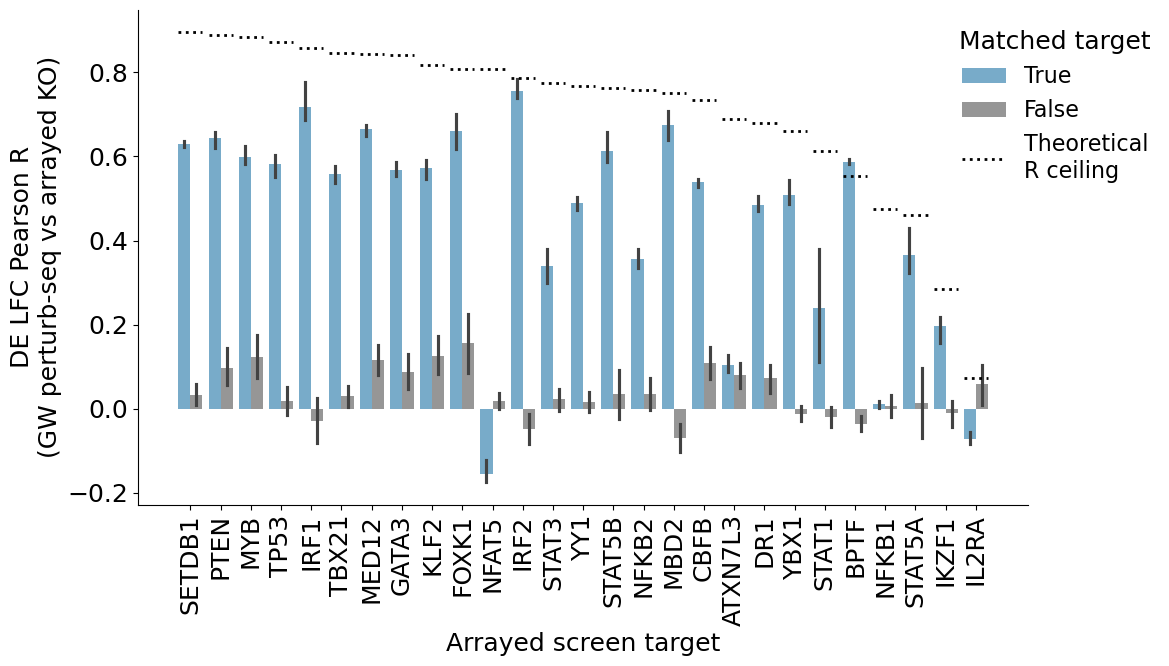

In [188]:
# Get mean r values and sort by same_target=True values
order = all_res[all_res['same_target']].groupby('gene_freimer')['r_ceiling'].mean().sort_values(ascending=False).index

# Set figure size
plt.figure(figsize=(12, 7))

# Create barplot with custom colors and ordered bars
ax = sns.barplot(data=all_res, x='gene_freimer', y='r', hue='same_target', 
            order=order,
            palette={True: '#6baed6', False: '#969696'},
            hue_order=[True, False]
            )
# Calculate mean ceiling for each target
ceiling_means = all_res[all_res['same_target']].groupby('gene_freimer')['r_ceiling'].mean()

# Plot mean ceiling as dotted lines
for i, gene in enumerate(order):
    mean_ceiling = ceiling_means[gene]
    ax.hlines(y=mean_ceiling, xmin=i-0.4, xmax=i+0.4, linestyles='dotted', colors='black', linewidth=2, 
              label='Theoretical\nR ceiling' if i==0 else None)

# Increase font sizes
plt.rcParams.update({'font.size': 18})
ax.tick_params(labelsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)

# Move legend outside and rename labels
ax.legend(bbox_to_anchor=(0.9, 1), loc='upper left',
         facecolor='white', frameon=False, title='Matched target', 
         fontsize=16, title_fontsize=18)
# Remove spines
sns.despine()


# Rotate x-axis labels and adjust layout
plt.xticks(rotation=90, ha='center')
plt.xlabel('Arrayed screen target')
plt.ylabel('DE LFC Pearson R\n(GW perturb-seq vs arrayed KO)')
plt.tight_layout()
plt.savefig('./results/ArrayedRNA_summary_barplot.pdf')
plt.savefig('./results/ArrayedRNA_summary_barplot.png')



In [171]:
de_stats[de_stats['target_name'] == 'NFKB1']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
18447,ENSG00000109320,NFKB1,Rest,287.0,54,36,90,-13.872222,True,147.248289,False,>10 DE genes,on-target KD


In [166]:
all_res[all_res['gene_GWT'] == 'NFAT5']

,r,r_ceiling,gene_GWT,gene_freimer,same_target,seed,n
41,-0.180780,0.815103,NFAT5,BPTF,False,412,2291
95,-0.277673,0.828591,NFAT5,DR1,False,412,2487
176,0.091633,0.795321,NFAT5,IKZF1,False,412,1529
392,-0.122093,0.816875,NFAT5,NFAT5,True,412,1402
419,-0.374637,0.805410,NFAT5,NFKB1,False,412,1509
446,0.508740,0.823820,NFAT5,NFKB2,False,412,2360
500,-0.021433,0.772363,NFAT5,SETDB1,False,412,1088
527,0.085428,0.799643,NFAT5,STAT1,False,412,1799
554,-0.062891,0.803829,NFAT5,STAT3,False,412,1200
635,-0.103897,0.786834,NFAT5,TBX21,False,412,1183


---

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

def estimate_sigma_ac(sigma_a, sigma_b):
    """
    Estimate correlated error component using PCA on two sigma vectors
    
    Parameters:
    -----------
    sigma_a, sigma_b : array-like
        Error standard deviations for variables a and b
        
    Returns:
    --------
    sigma_ac : float
        Estimated correlated error standard deviation
    """
    
    # Convert to numpy arrays
    sigma_a = np.array(sigma_a)
    sigma_b = np.array(sigma_b)
    
    # Create 2-column matrix: [sigma_a, sigma_b]
    sigma_matrix = np.column_stack([sigma_a, sigma_b])
    
    # Compute first PC
    pca = PCA(n_components=1)
    pc1_scores = pca.fit_transform(sigma_matrix)
    
    # Get PC1 loadings and explained variance
    pc1_loadings = pca.components_[0]  # Shape: (2,)
    pc1_variance = pca.explained_variance_[0]
    
    # Estimate sigma_ac from PC1
    # Method: Use geometric mean of absolute loadings times sqrt of PC1 variance
    avg_loading = np.mean(np.abs(pc1_loadings))
    sigma_ac = avg_loading * np.sqrt(pc1_variance)
    
    return sigma_ac